RUL estimé : 33.31 heures


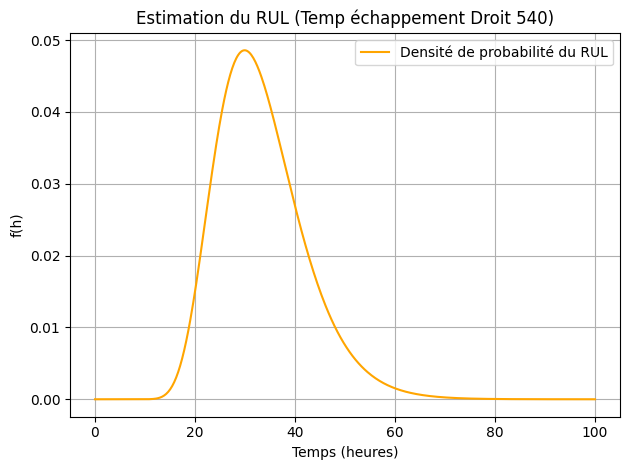

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Charger les données
df = pd.read_excel(r"C:\Users\hp\Desktop\Sensor1.xlsx")
df = df.sort_values(by="Heure").reset_index(drop=True)

# Convertir le temps en heures
t0 = df["Heure"].iloc[0]
df["t (h)"] = (df["Heure"] - t0).dt.total_seconds() / 3600.0

# Extraire temps et valeurs capteur
t = df["t (h)"].values
x = df["Temp échappement Droit 540"].values.astype(float)

# Paramètres du modèle
w = 618.0     # Seuil critique
sigma = 5.0   # Écart-type du bruit
Q = 0.01      # Bruit de process Kalman

# Estimation de la dérive mu_t par filtre de Kalman
mu_hat = [0.0]
P = [1.0]

for i in range(1, len(t)):
    dt = t[i] - t[i-1]
    mu_pred = mu_hat[-1]
    P_pred = P[-1] + Q
    Ft = dt**2 * P_pred + sigma**2 * dt
    Kt = dt * P_pred / Ft
    mu_new = mu_pred + Kt * (x[i] - x[i-1] - dt * mu_pred)
    P_new = P_pred - (dt**2 * P_pred**2) / Ft
    mu_hat.append(mu_new)
    P.append(P_new)

mu_hat = np.array(mu_hat)

# Fonction de densité du RUL
def rul_density(h, Xt, mu_t, sigma):
    num = w - Xt
    denom = np.sqrt(2 * np.pi * h**3 * sigma**2)
    exponent = -((w - Xt - mu_t * h)**2) / (2 * h * sigma**2)
    return (num / denom) * np.exp(exponent)

# RUL pour la dernière observation
Xt_last = x[-1]
mu_last = mu_hat[-1]
fdp_func = lambda h: rul_density(h, Xt_last, mu_last, sigma)

# RUL moyen
expected_rul = quad(lambda h: h * fdp_func(h), 0.01, 100)[0]
print(f"RUL estimé : {expected_rul:.2f} heures")

# Affichage de la densité de probabilité
h_range = np.linspace(0.01, 100, 500)
fdp_vals = [fdp_func(h) for h in h_range]

plt.plot(h_range, fdp_vals, label="Densité de probabilité du RUL", color='orange')
plt.xlabel("Temps (heures)")
plt.ylabel("f(h)")
plt.title("Estimation du RUL (Temp échappement Droit 540)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# === Étape 1 : Charger les données ===
df = pd.read_excel(r"C:\Users\hp\Desktop\Sensor1.xlsx")
df = df.sort_values(by="Heure").reset_index(drop=True)

# Convertir les timestamps en heures écoulées
t0 = df["Heure"].iloc[0]
df["t (h)"] = (df["Heure"] - t0).dt.total_seconds() / 3600.0
t = df["t (h)"].values
x = df["Temp échappement Droit 540"].values.astype(float)

# === Étape 2 : Paramètres du modèle ===
w = 800   # Seuil critique
sigma = 5.0
Q = 0.01

# === Étape 3 : Filtrage de Kalman pour mu_t ===
mu_hat = [0.0]
P = [1.0]

for i in range(1, len(t)):
    dt = t[i] - t[i-1]
    mu_pred = mu_hat[-1]
    P_pred = P[-1] + Q
    Ft = dt**2 * P_pred + sigma**2 * dt
    Kt = dt * P_pred / Ft
    mu_new = mu_pred + Kt * (x[i] - x[i-1] - dt * mu_pred)
    P_new = P_pred - (dt**2 * P_pred**2) / Ft
    mu_hat.append(mu_new)
    P.append(P_new)

mu_hat = np.array(mu_hat)

# === Étape 4 : Définir la densité de probabilité du RUL ===
def rul_density(h, Xt, mu_t, sigma):
    num = w - Xt
    denom = np.sqrt(2 * np.pi * h**3 * sigma**2)
    exponent = -((w - Xt - mu_t * h)**2) / (2 * h * sigma**2)
    return (num / denom) * np.exp(exponent)

def compute_expected_rul(Xt, mu_t, sigma=5.0, h_max=100):
    fdp_func = lambda h: rul_density(h, Xt, mu_t, sigma)
    try:
        return quad(lambda h: h * fdp_func(h), 0.01, h_max)[0]
    except:
        return np.nan

# === Étape 5 : Calcul du RUL pour chaque point ===
rul_estimates = []
for i in range(len(t)):
    Xt_i = x[i]
    mu_i = mu_hat[i]
    rul_i = compute_expected_rul(Xt_i, mu_i, sigma)
    rul_estimates.append(rul_i)

df["RUL estimé (heures)"] = rul_estimates

# === Étape 6 : Sauvegarder le fichier ===
df.to_excel("Sensor1_RUL_output.xlsx", index=False)
print("✅ Fichier sauvegardé sous : Sensor1_RUL_output.xlsx")


✅ Fichier sauvegardé sous : Sensor1_RUL_output.xlsx


In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Charger les données avec les colonnes : 't (h)' et 'RUL estimé (heures)'
df = pd.read_excel("Sensor1_RUL_output.xlsx")

# === Paramètre : heure de défaillance réelle (à ajuster selon ton cas) ===
t_failure = 10.0  # heure de panne réelle après la 1re observation

# === Calcul du RUL réel ===
df["RUL réel (heures)"] = t_failure - df["t (h)"]

# === Supprimer les lignes contenant des NaN dans la prédiction ===
valid_mask = ~df["RUL estimé (heures)"].isna()
y_true = df.loc[valid_mask, "RUL réel (heures)"].values
y_pred = df.loc[valid_mask, "RUL estimé (heures)"].values

# === Calcul des métriques ===
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"✅ Évaluation du modèle RUL :")
print(f"   RMSE  : {rmse:.2f} heures")
print(f"   MAE   : {mae:.2f} heures")
print(f"   MAPE  : {mape:.2f} %")

# Optionnel : sauvegarder les colonnes dans un nouveau fichier
df.to_excel("Sensor1_RUL_evaluation.xlsx", index=False)


✅ Évaluation du modèle RUL :
   RMSE  : 4760.14 heures
   MAE   : 4044.88 heures
   MAPE  : 104.28 %
